# User path setting

In [1]:
# path for the transfer learning models
model_path = r"G:\我的云端硬盘\DeepLearning\MagNet_dataExpand_comb_shift_flip"

# Running

## Defult path setting

In [2]:
# path using \ instead of /
model_saved_name="model_colab.ckpt"
dataset_path=r"data\std_dataset"

## Processing...

In [3]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import NW_LSTM
import NN_DataLoader

# Check if CUDA is available and if so, set the device to GPU
device = torch.device("cpu")
print("Device using ", device)



class MyDataset(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]



Device using  cpu


material_name:  modelA


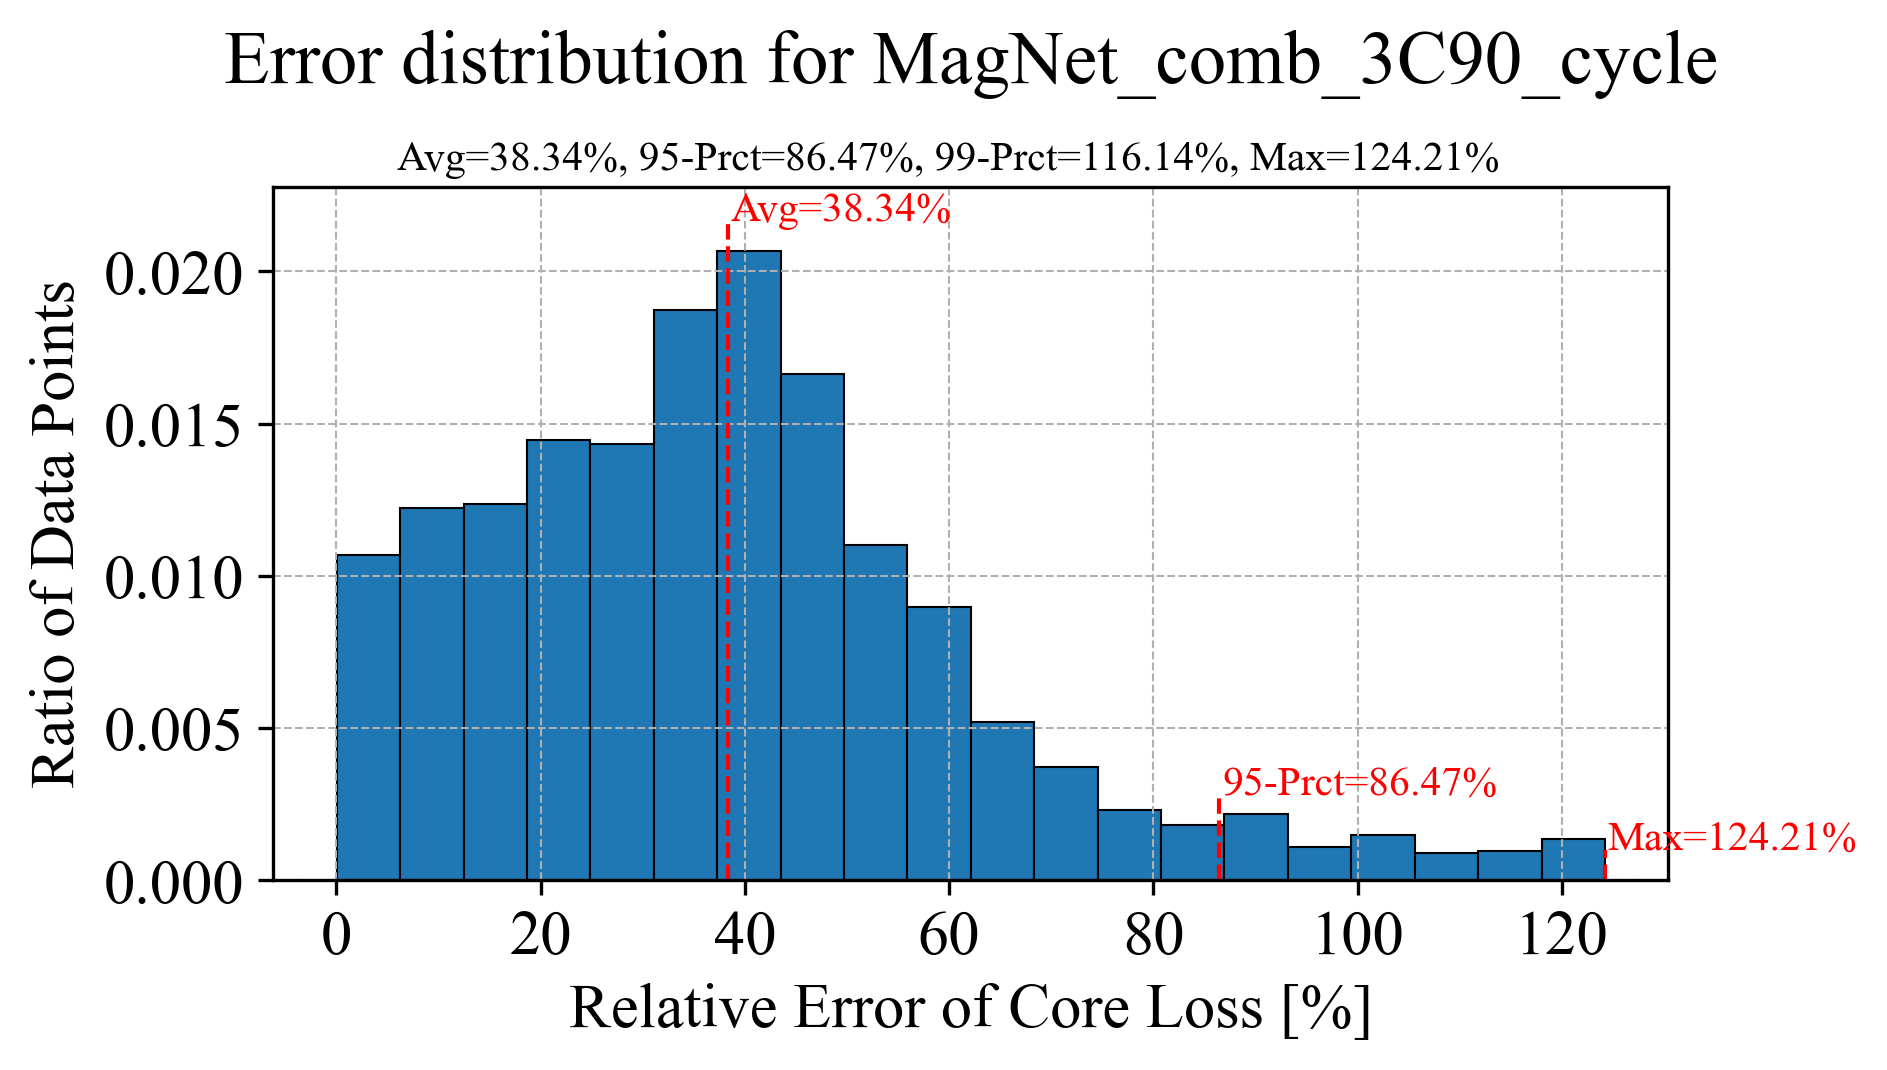

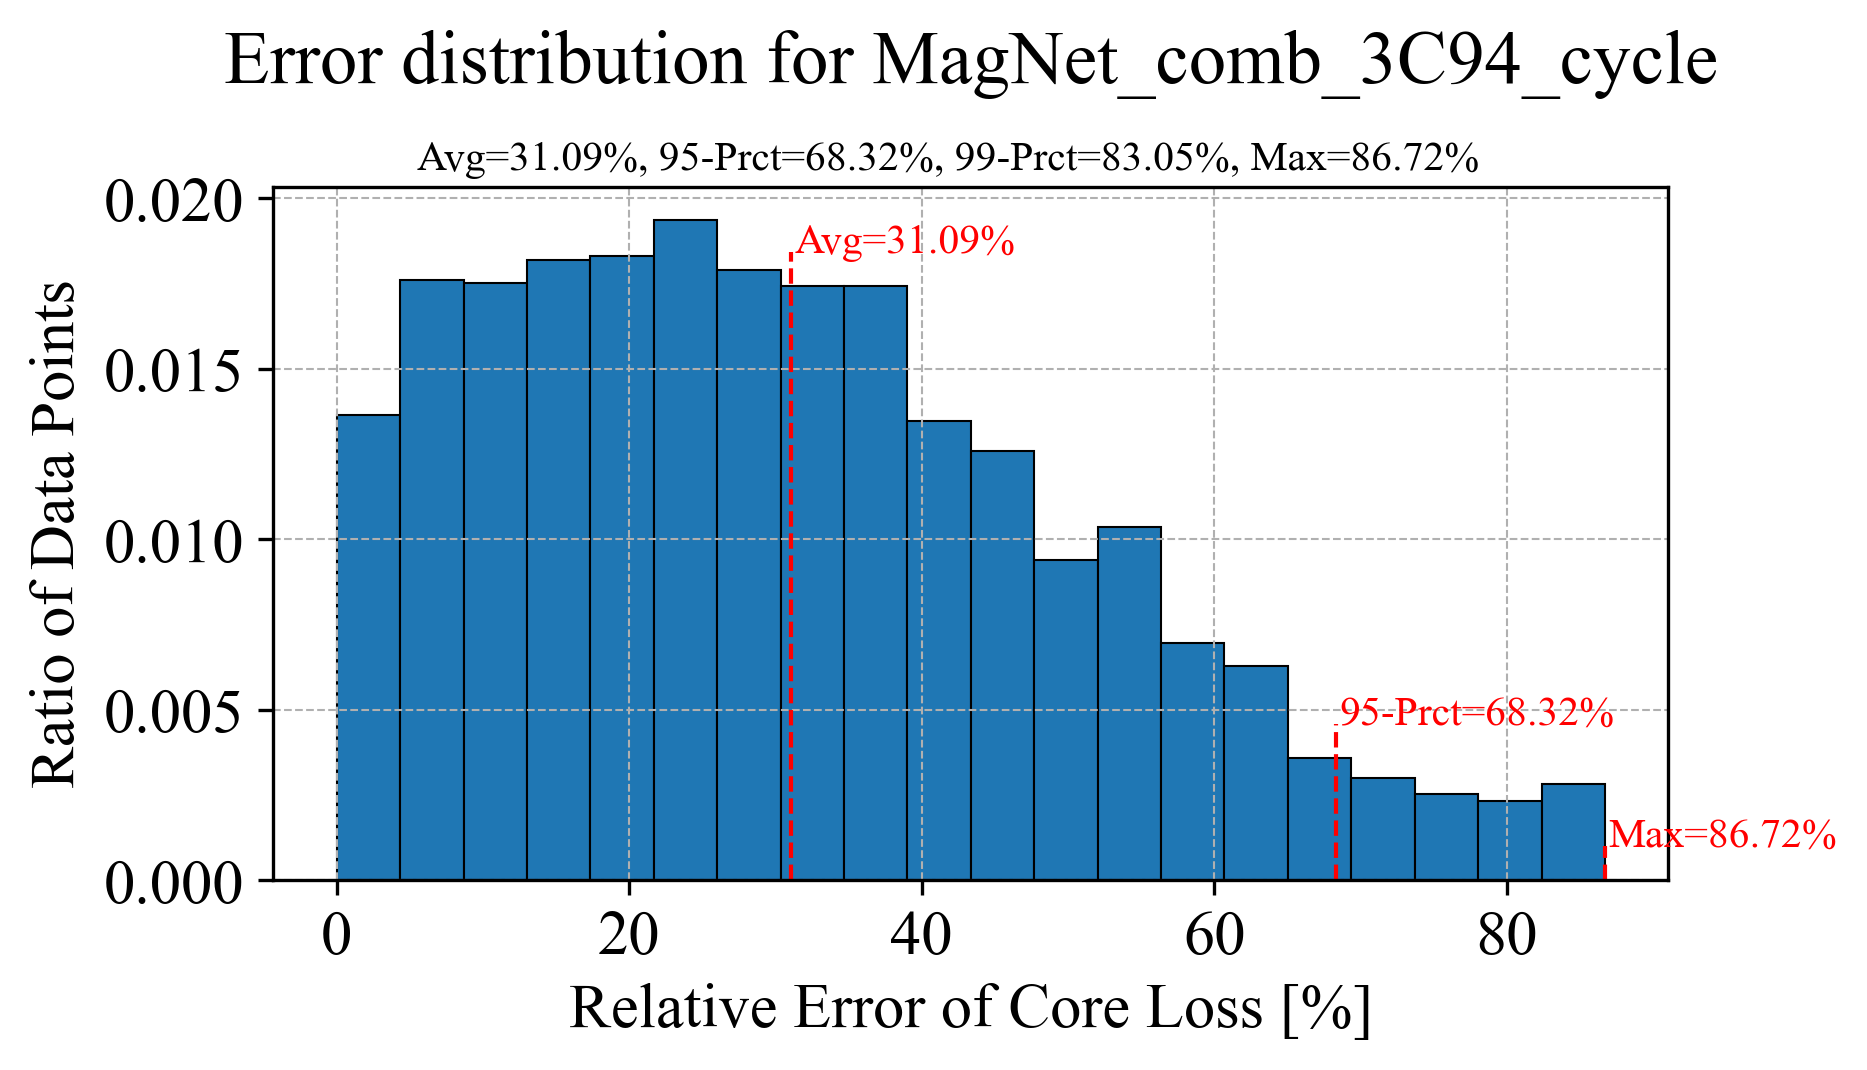

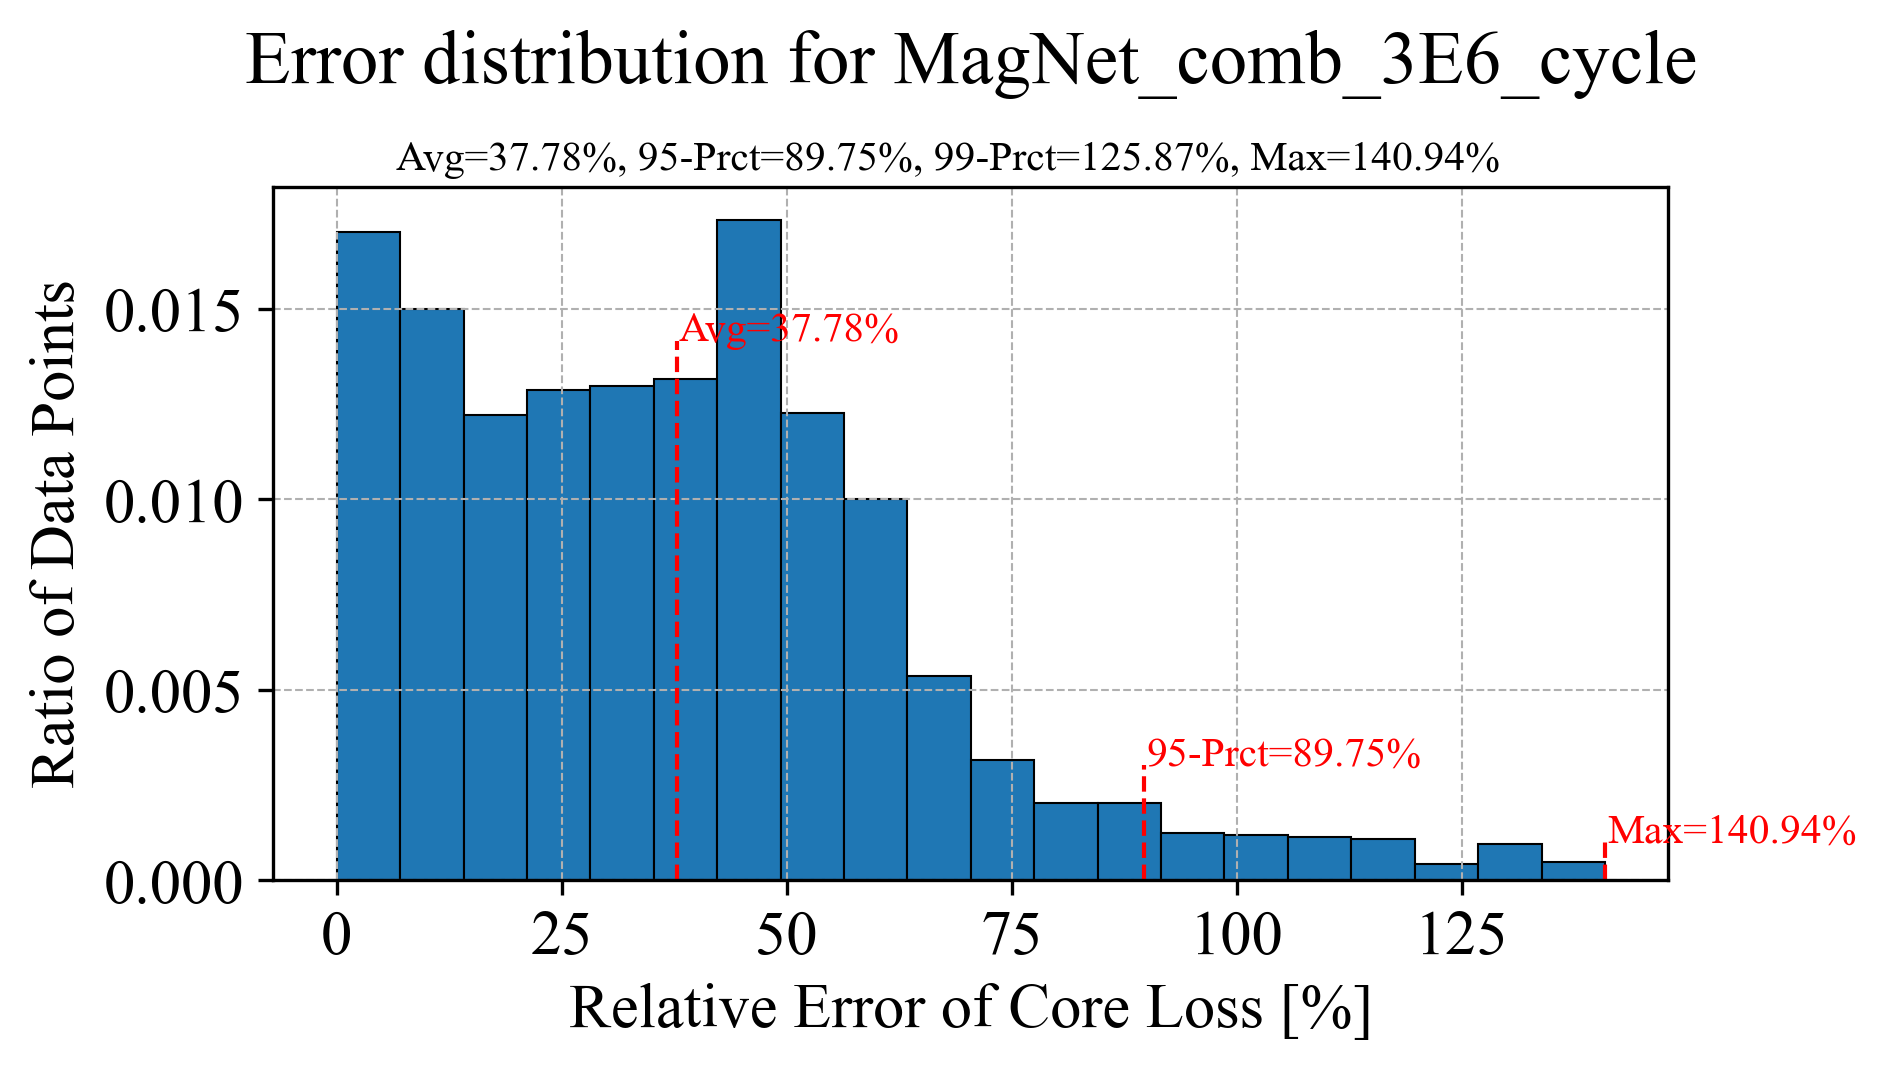

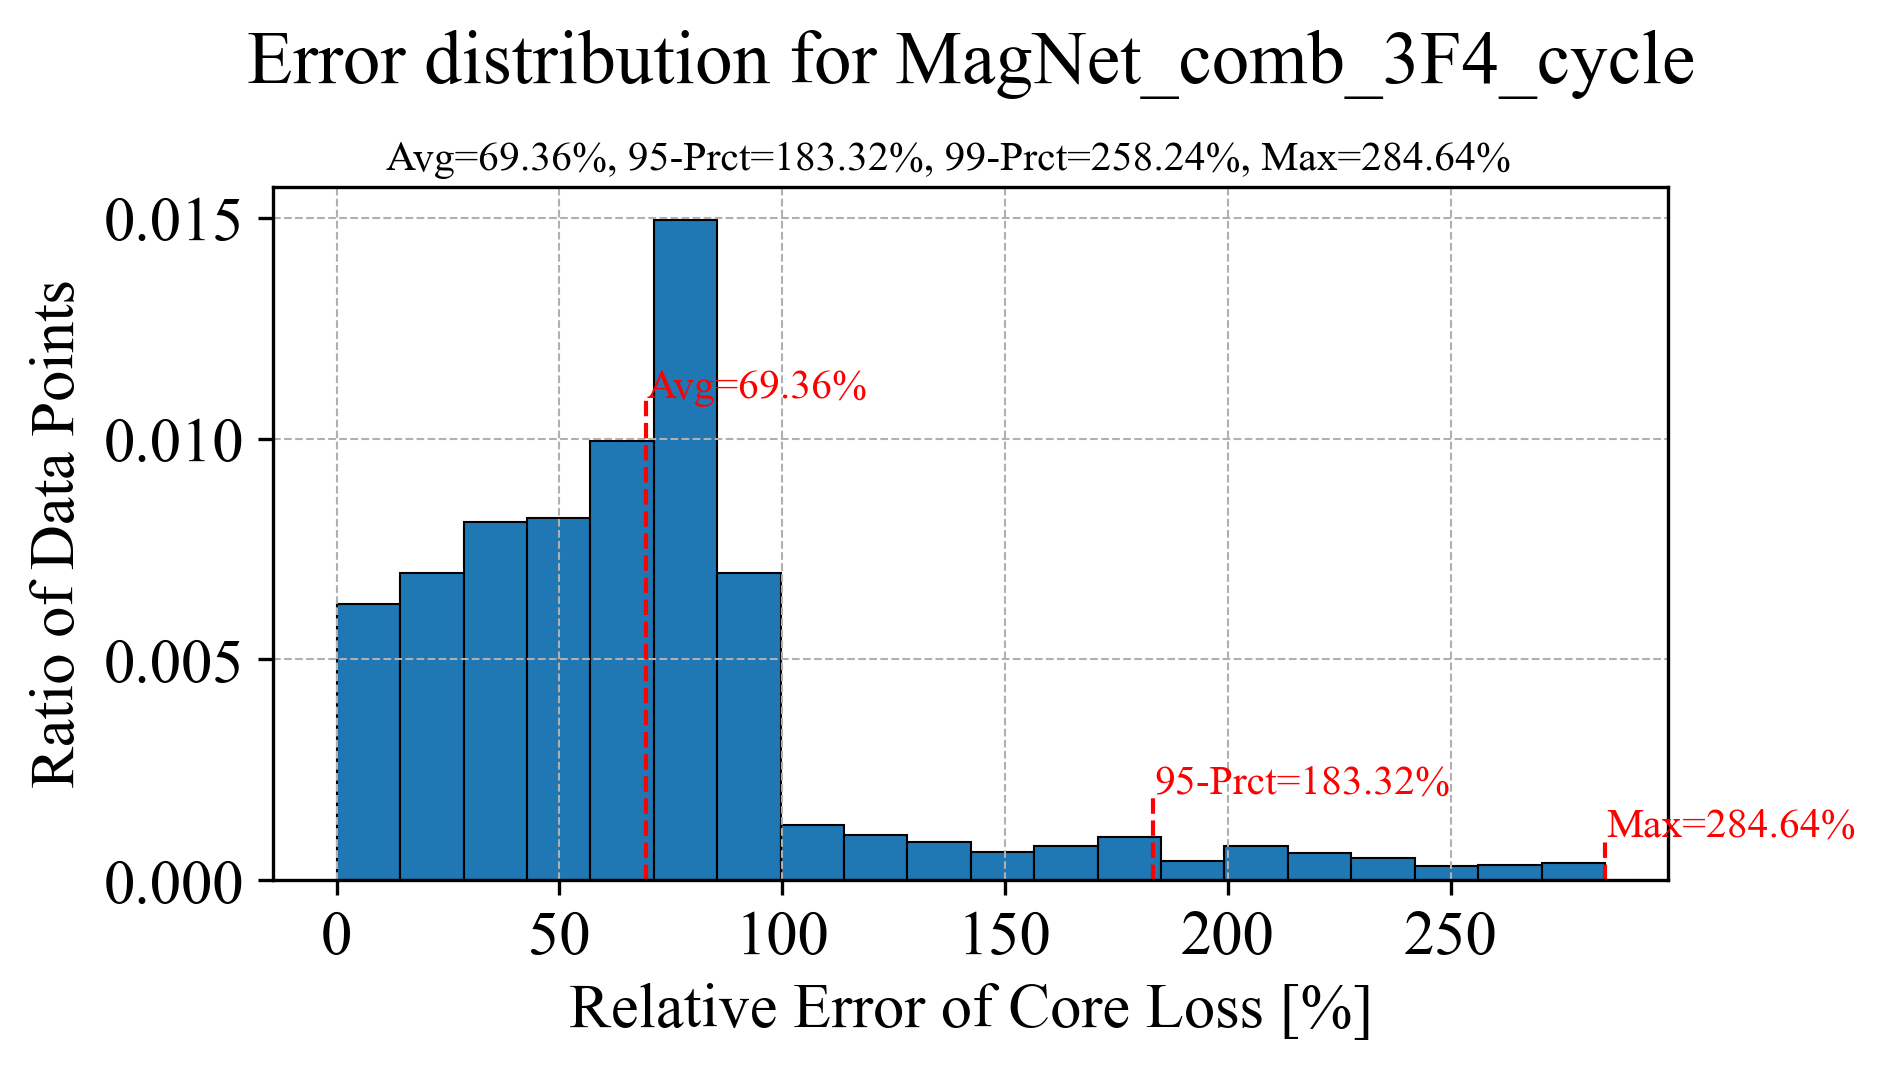

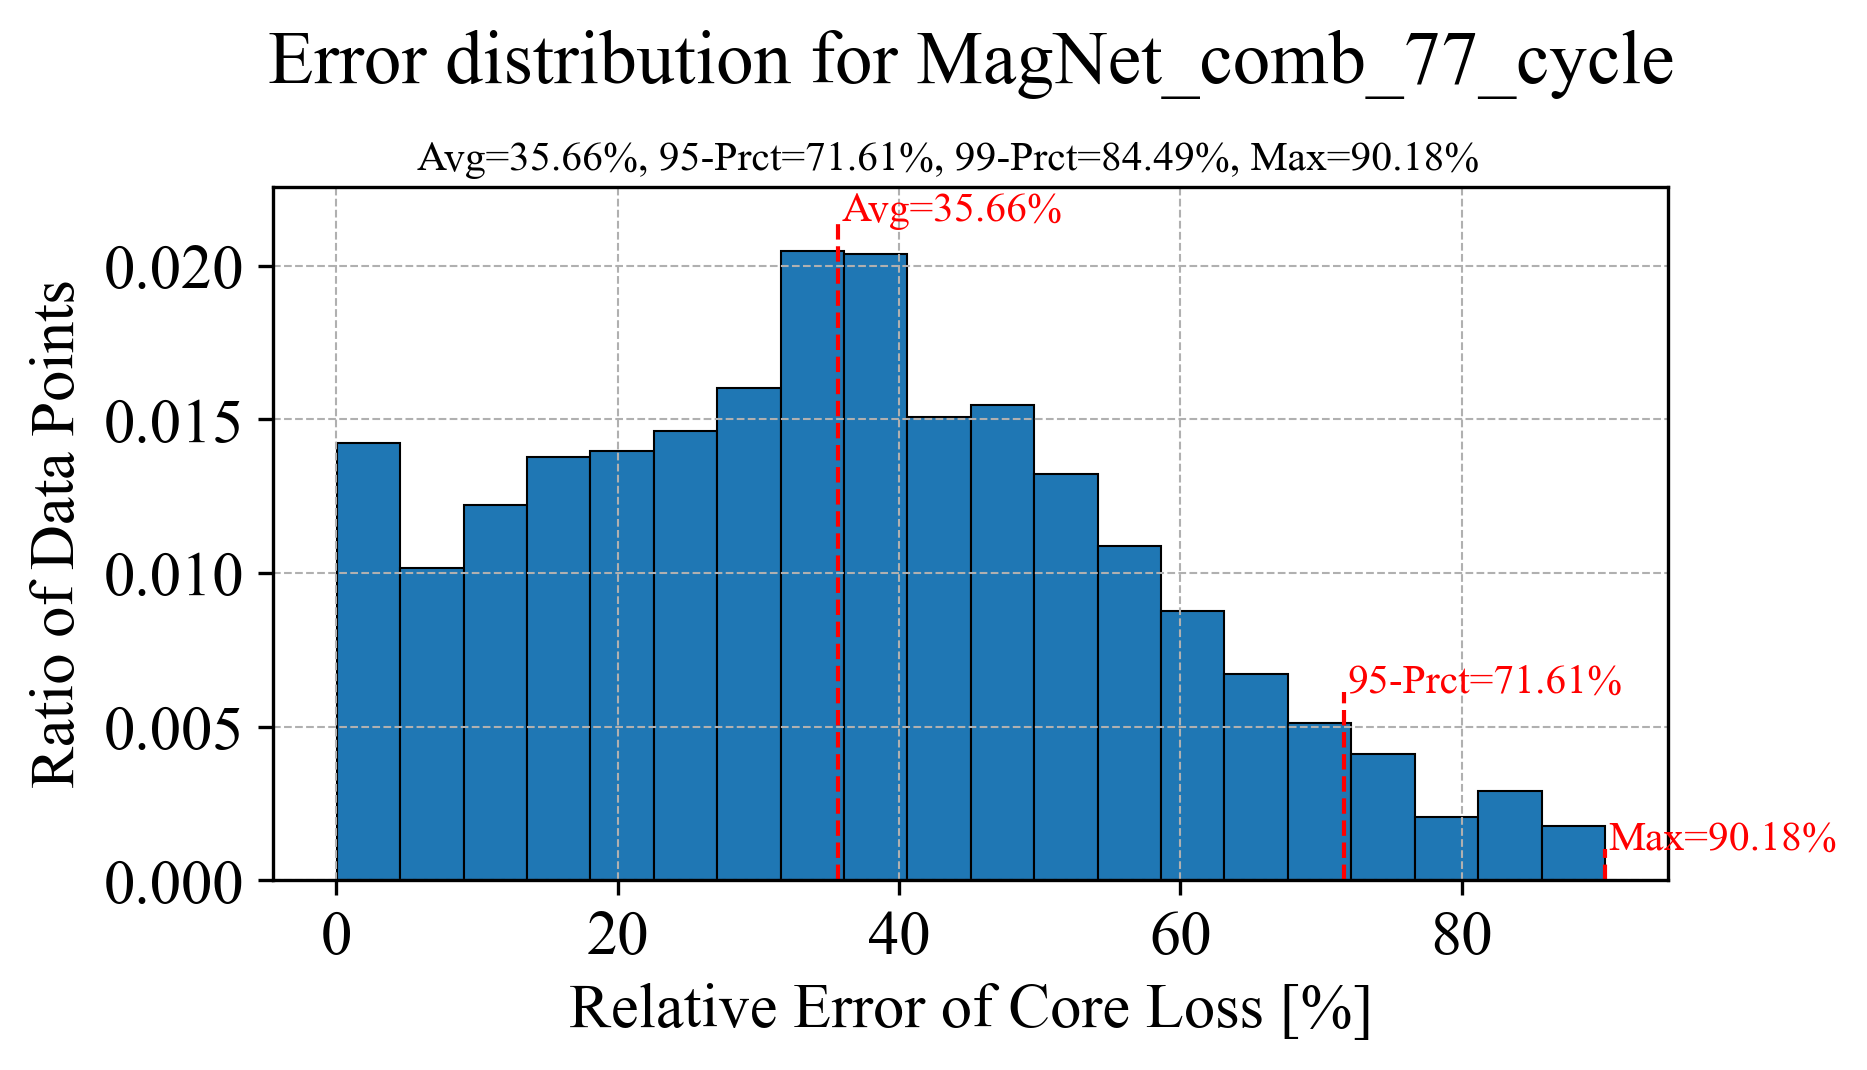

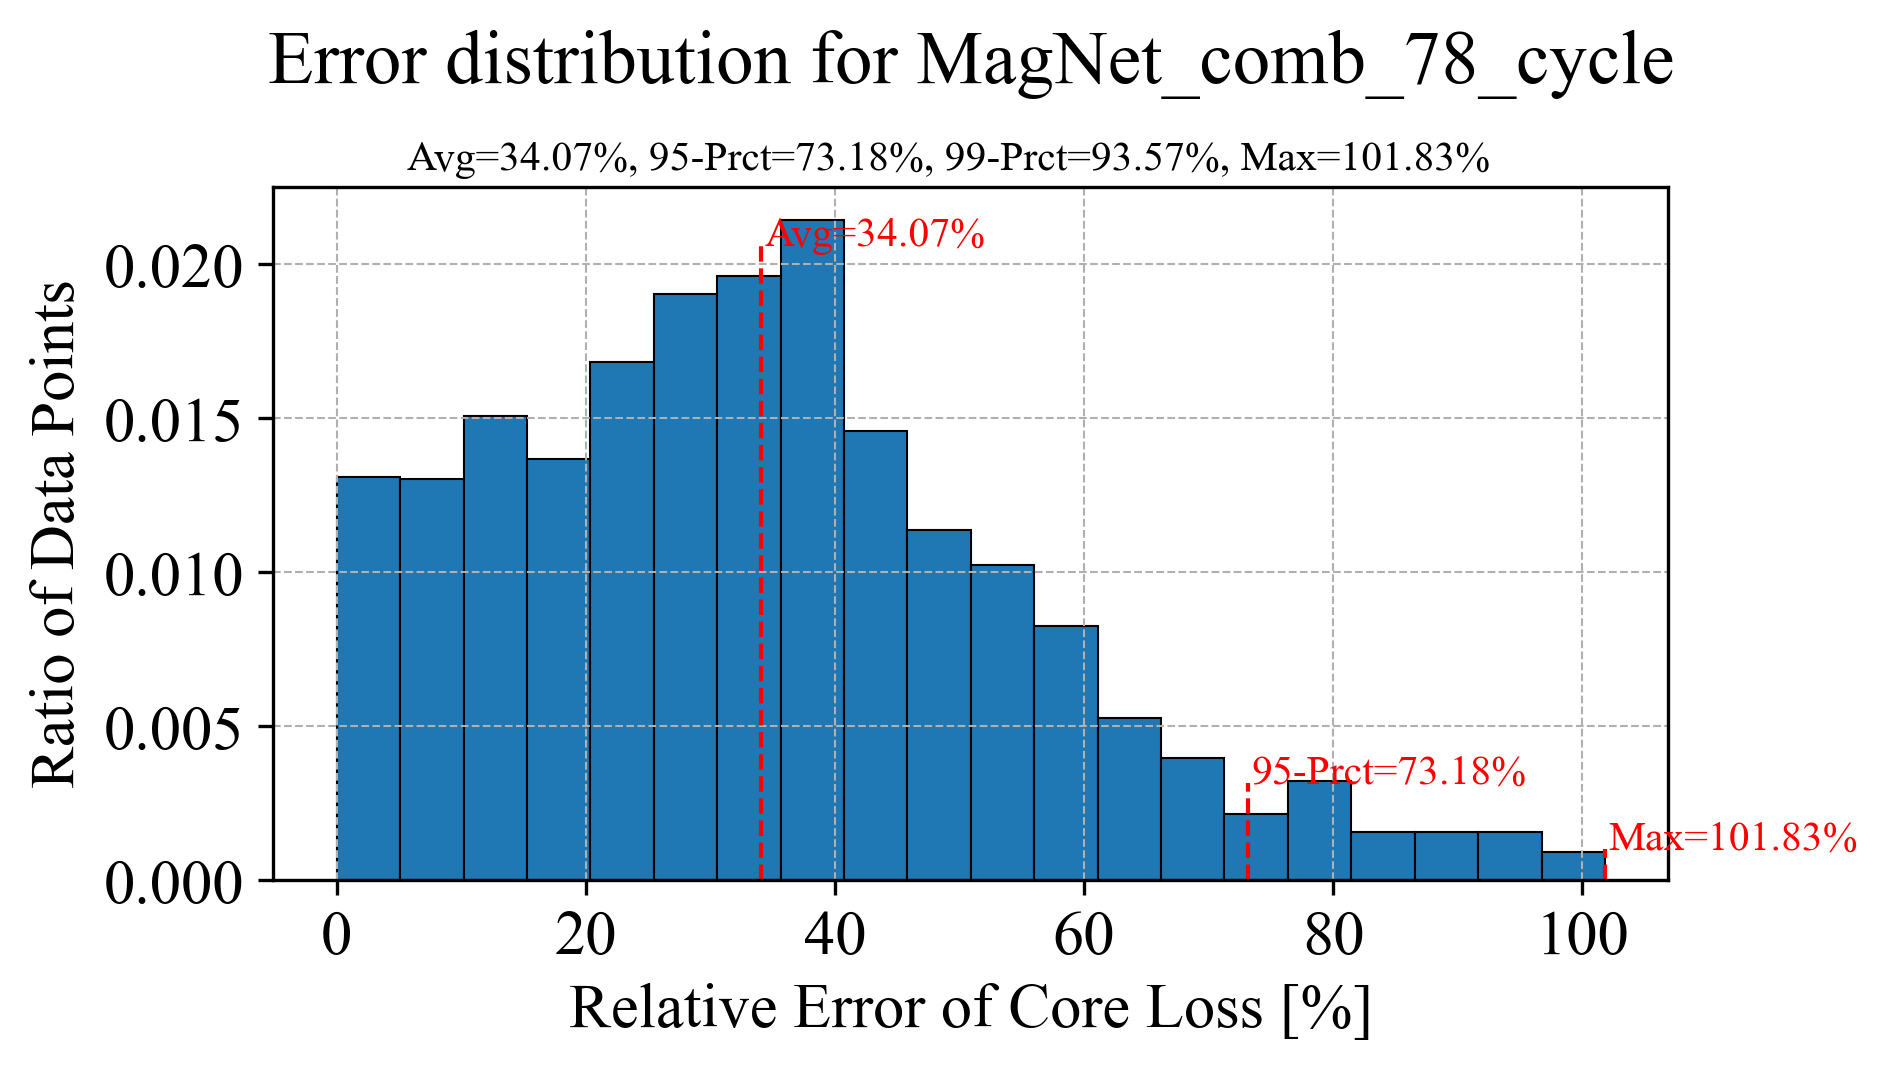

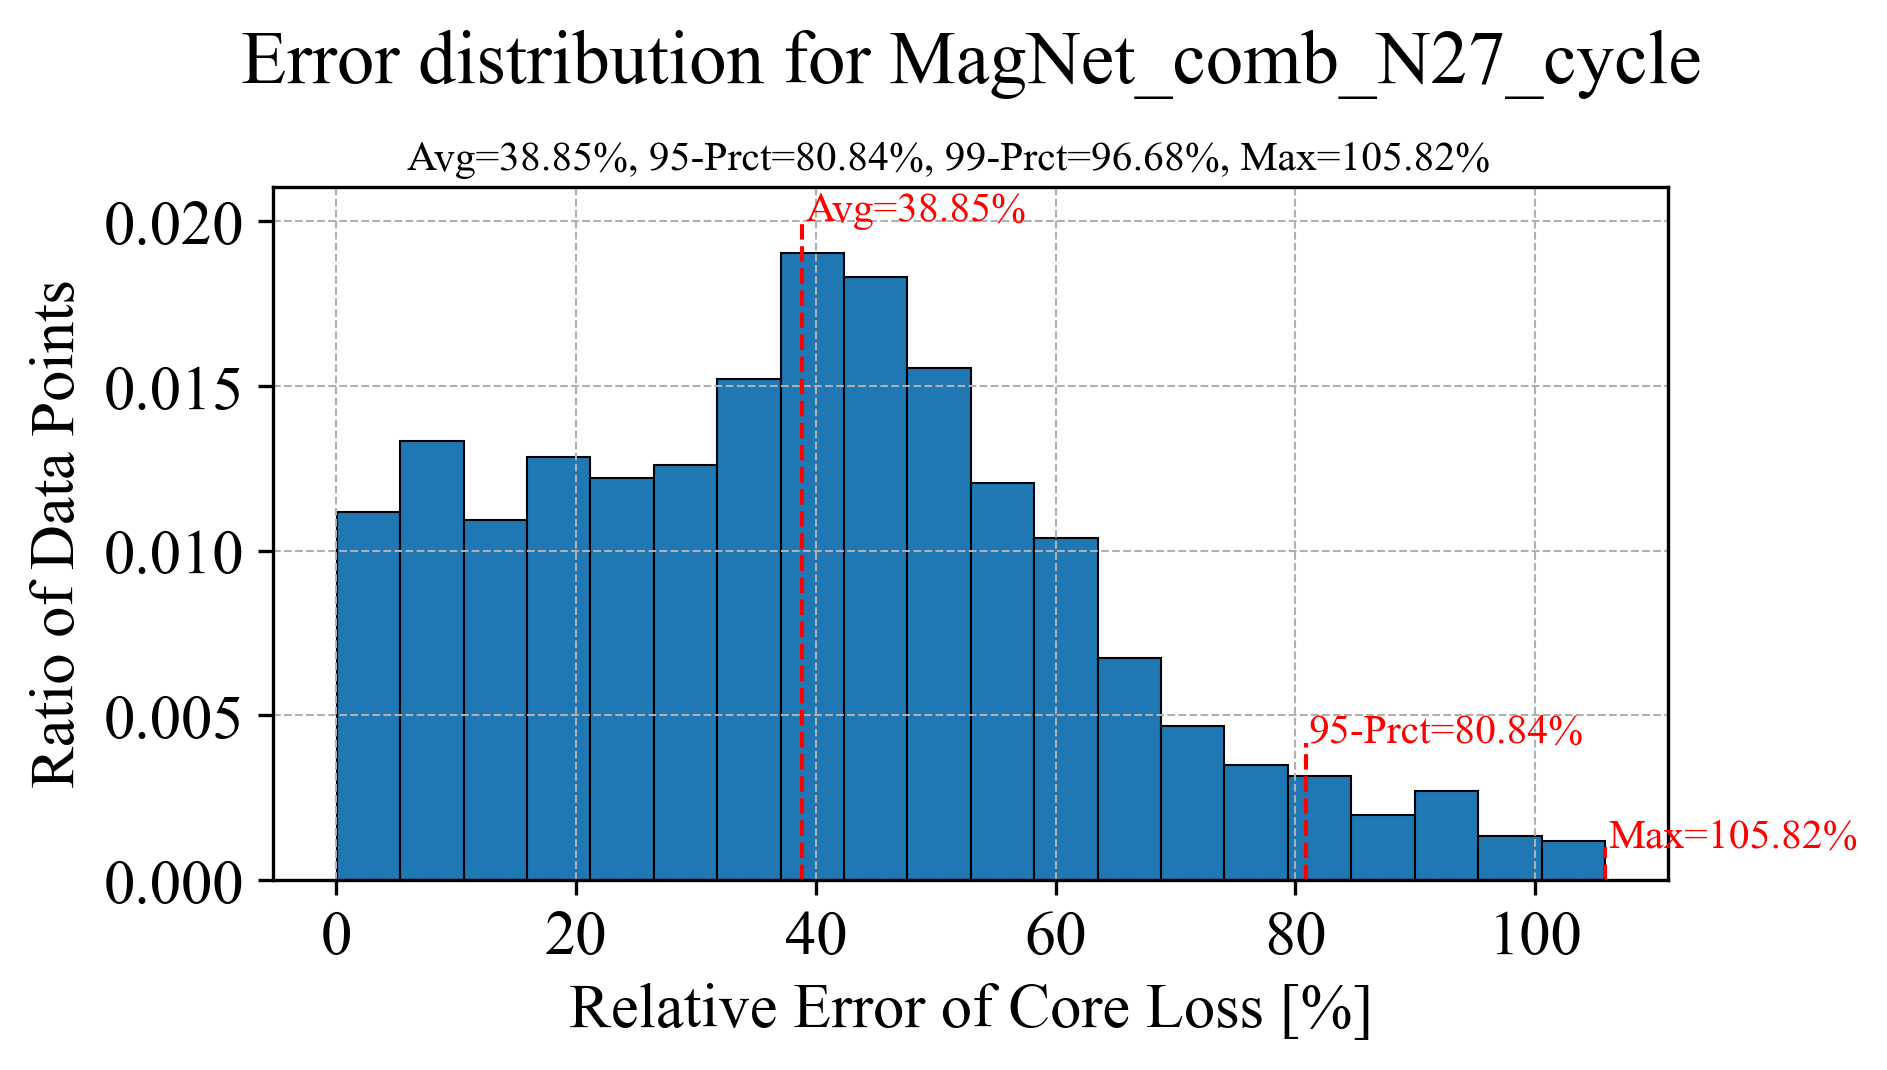

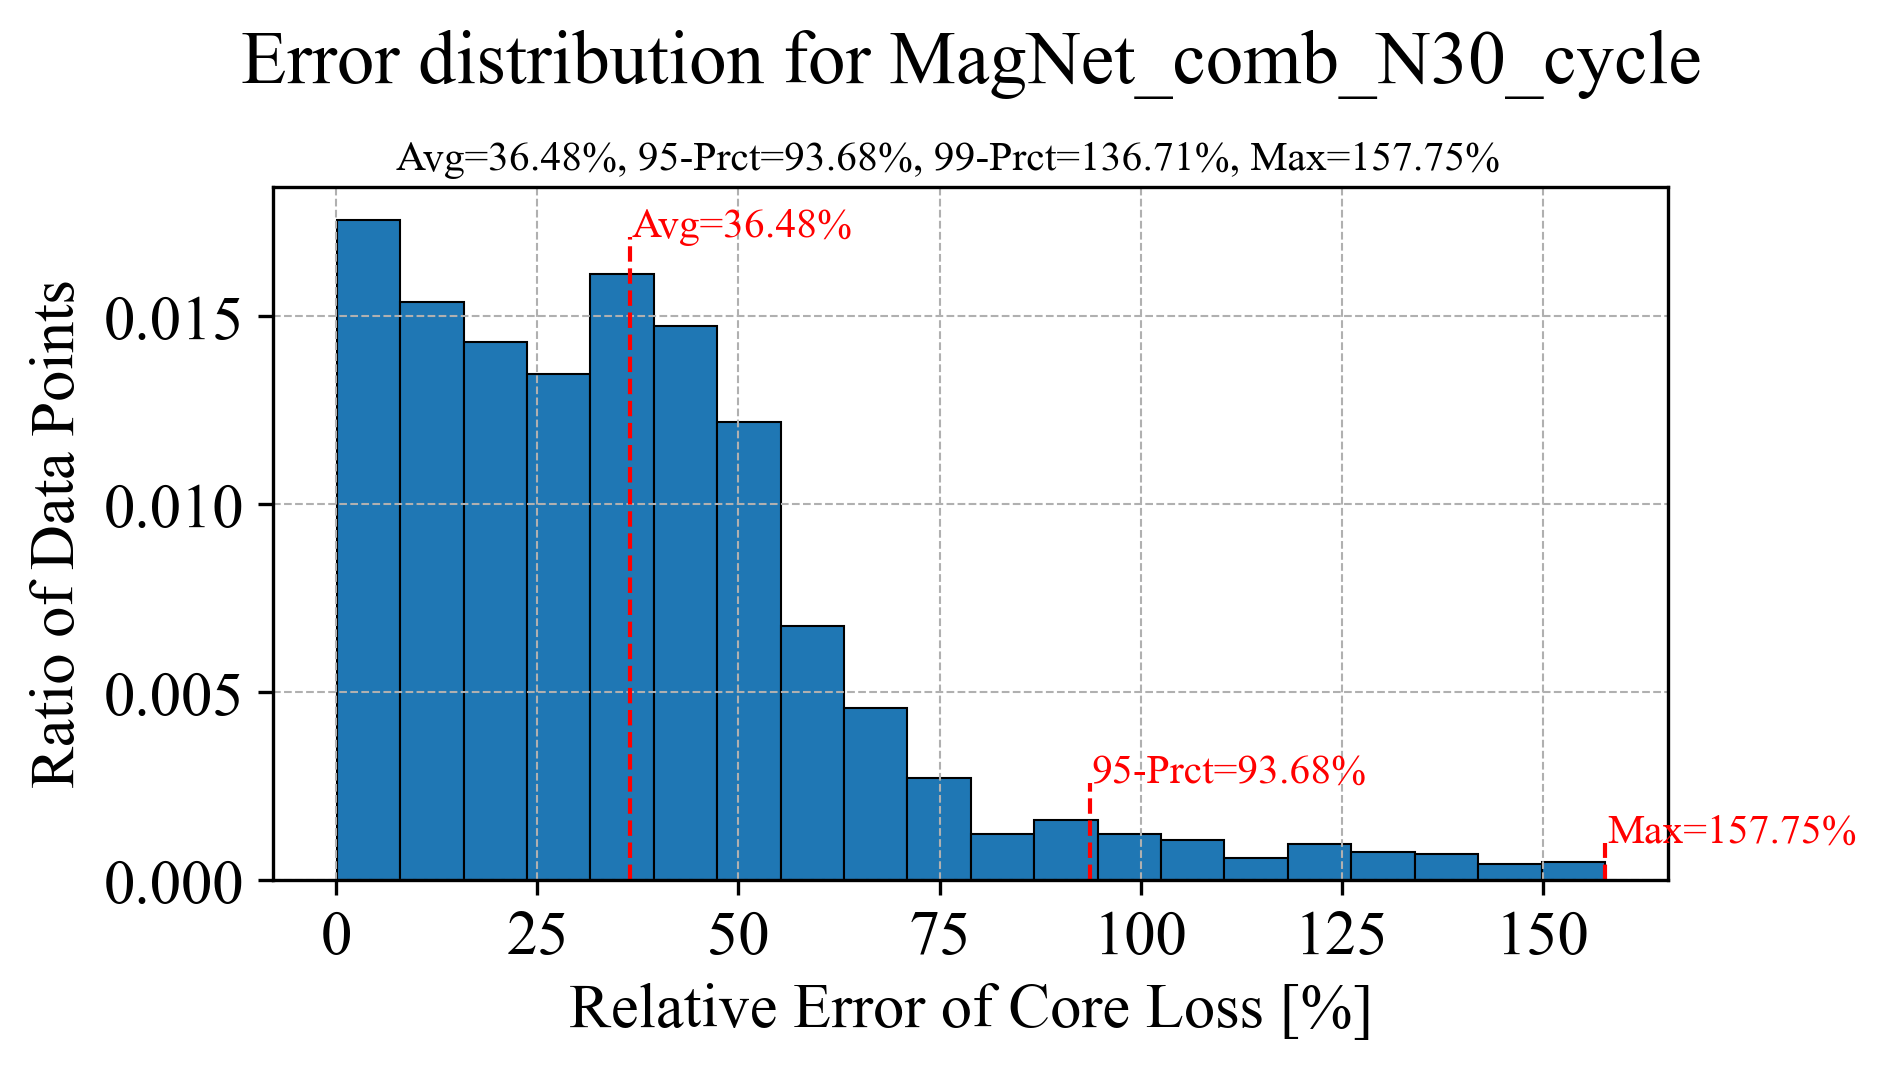

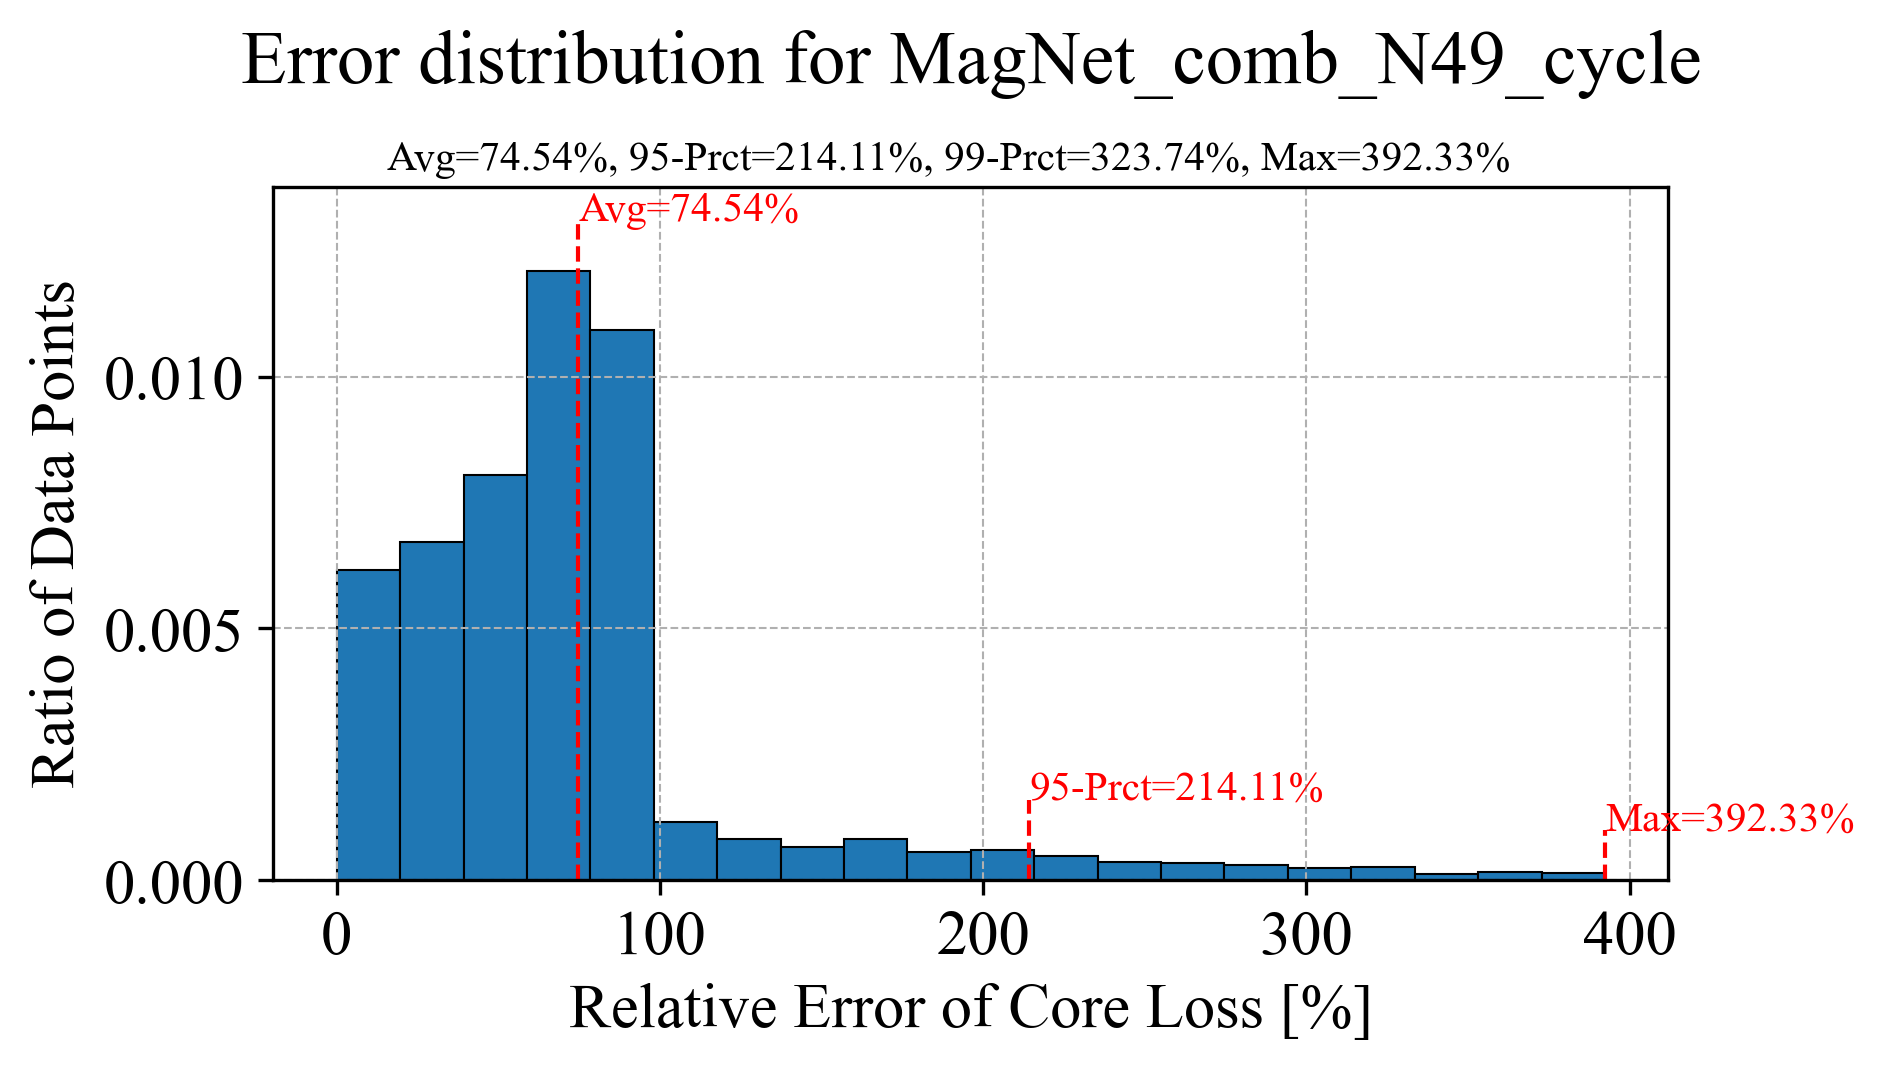

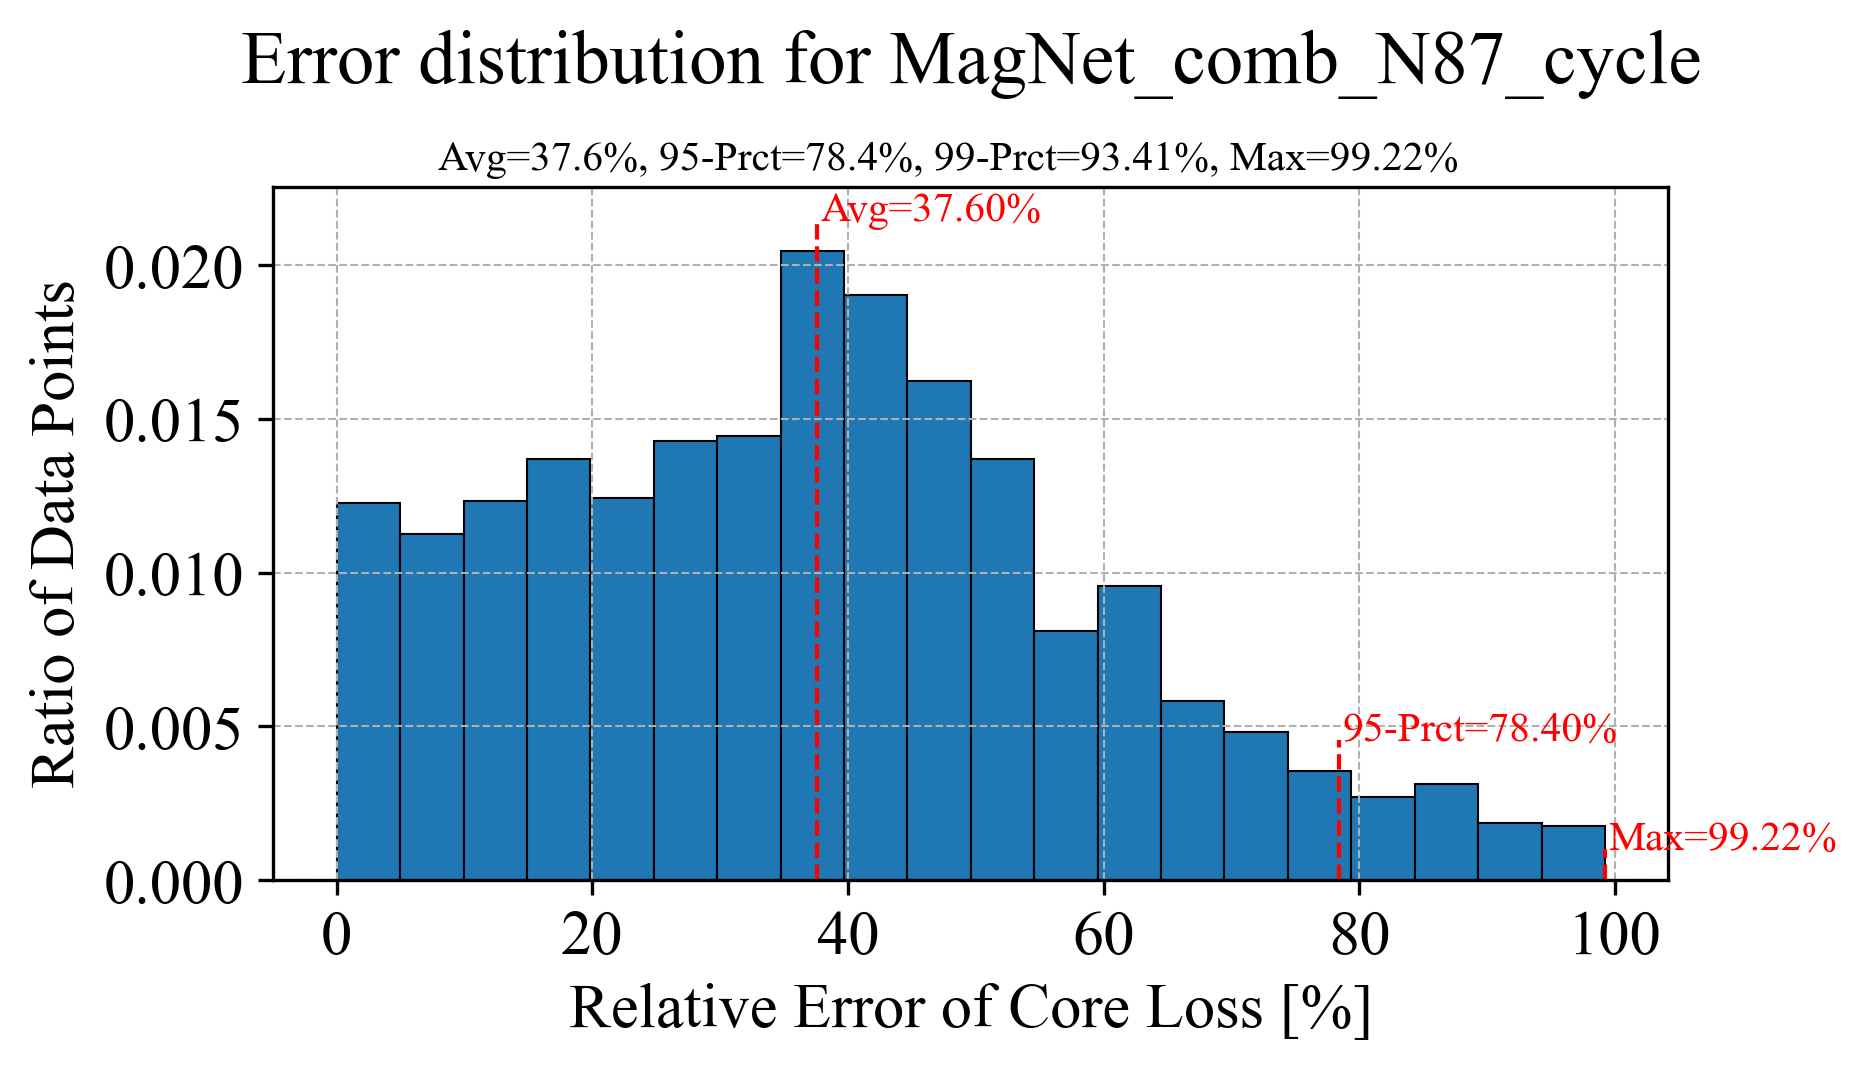

In [4]:
import Maglib
import os
import MagNet
import linear_std

# magData = Maglib.MagLoader(dataset_path+r"\test.mat")
magData = Maglib.MagLoader(dataset_path+r"\data_processed.mat")

######################

# get current folder name
material_name = os.path.basename(os.getcwd())
material_name = material_name.split('_')[2]
print("material_name: ", material_name)

std_loss = linear_std.linear_std()
std_loss.load(dataset_path+r"\std_loss.stdd")

std_temp = linear_std.linear_std()
std_temp.load(dataset_path+r"\std_temp.stdd")

std_freq = linear_std.linear_std()
std_freq.load(dataset_path+r"\std_freq.stdd")

std_b = linear_std.linear_std()
std_b.load(dataset_path+r"\std_b.stdd")


data_b = std_b.unstd(magData.b)
data_temp = std_temp.unstd(magData.temp)
data_freq = std_freq.unstd(magData.freq)
data_loss = std_loss.unstd(magData.loss)

# get all folder name in pre_model folder
import os
import glob
model_list = glob.glob(model_path+r"\*")
# model_list = [os.path.basename(x) for x in model_list]
model_list = [x for x in model_list if '.' not in x]

rank_list = []

idx = 0
for model_path in model_list:
    pred_loss=MagNet.MagLoss(
        data_b,data_temp,data_freq,
        model_path+r"\model_colab.ckpt",
        model_path+r"\data\std_dataset",
                             )

    data_loss=data_loss[:pred_loss.shape[0]]

    mean_relv=np.mean(pred_loss/data_loss)

    pred_loss=pred_loss/mean_relv   # whether to use mean_relv or not
    relv_err=np.abs(pred_loss-data_loss)/data_loss
    # filter out the biggest 3% data
    relv_err=np.sort(relv_err,axis=0)
    relv_err=relv_err[:int(relv_err.shape[0]*0.98),:]

    material_name=os.path.basename(model_path)

    MagNet.Mag_plot(material_name,relv_err,"",0)

    variance=np.var(pred_loss/data_loss,axis=0)
    #rank_list.append([material_name,variance,mean_relv])
    rank_list.append([model_path,variance,mean_relv,idx])
    idx += 1



In [5]:
# sort the rank_list
rank_list.sort(key=lambda x:x[1])
rank_list

best_md=rank_list[0]
print("best model: ",best_md)

# save the path of best model in txt file
with open("data\\best_model.txt","w") as f:
    f.write(best_md[0])
    f.write("\n")
    f.write(str(best_md[2]))
    f.close()
print("best model saved in best_model.txt")

best model:  ['G:\\我的云端硬盘\\DeepLearning\\MagNet_dataExpand_comb_shift_flip\\MagNet_comb_3C94_cycle', array([0.15652408], dtype=float32), 0.29856083, 1]
best model saved in best_model.txt
